In [158]:
import hopsy as hp
import numpy as np
import matplotlib.pyplot as plt

import time
import dill

from concurrent.futures import ProcessPoolExecutor as NestablePool
from multiprocessing import Pool

In [159]:
POSITION = [0,1]
DIPOLE_MOMENT = 2

def flatten(items):
    return [item for sublist in items for item in sublist] if isinstance(items, list) else items.flatten()

class CanonicalEnsemble():
    """
        Canonical Ensemble with potentials for chains of magnetic dipoles, 
        taken from https://pubs.rsc.org/en/content/articlelanding/2020/NR/D0NR01646B#!divAbstract
    """
    def __init__(self, K_f = 2.5, r_f = 2, sigma = 1, H = 1, beta = 1, eps = 1, mu_max = 1):
        self.K_f = K_f
        self.r_f = r_f
        self.sigma = sigma
        self.r_cut = 2**(1/6) * sigma
        self.H = H
        self.H_field = np.array([0, H])
        self.beta = beta
        self.eps = eps
        self.mu_max = mu_max
        self.U_LJ_cut = 4 * self.eps * ((self.sigma / self.r_cut)**12 - (self.sigma / self.r_cut)**6)
        
    def compute_negative_log_likelihood(self, x):
        return self.hamiltonian(x)
    
    def hamiltonian(self, x):
        return self.beta * (self.fene_potential(x) + self.wca_potential(x) + self.zeeman_potential(x) + self.interparticle_potential(x))
        
    def fene_potential(self, x):
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        U = 0
        n = len(x)
        for i in range(n-1):
            r = np.linalg.norm(x[i][POSITION] - x[i+1][POSITION])
            U += (-self.K_f * self.r_f**2) * np.log(1 - (r / self.r_f)**2) / 2 if (r/self.r_f)**2 < 1 else np.inf

        return U

    def interparticle_potential(self, x):
        """
            Following (3) in https://pubs.rsc.org/en/content/articlelanding/2020/NR/D0NR01646B#!divAbstract
        """
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        U = 0
        n = len(x)
        for i in range(n):
            for j in range(i+1, n):
                r_ij = x[i][POSITION] - x[j][POSITION]
                r = np.linalg.norm(r_ij)
                
                mu_i = self.mu_max * np.array([np.cos(x[i][DIPOLE_MOMENT]), np.sin(x[i][DIPOLE_MOMENT])])
                mu_j = self.mu_max * np.array([np.cos(x[j][DIPOLE_MOMENT]), np.sin(x[j][DIPOLE_MOMENT])])
                
                U += np.dot(mu_i, mu_j) / np.linalg.norm(r)**3 - 3 * np.dot(mu_i, r_ij) * np.dot(mu_j, r_ij) / np.linalg.norm(r)**5 #if r != 0 else np.inf
        
        return U

    def wca_potential(self, x):
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        n = len(x)
        U = 0
        for i in range(n):
            for j in range(i+1, n):
                r = np.linalg.norm(x[i][POSITION] - x[j][POSITION])
                U += 0 if r > self.r_cut else 4 * self.eps * ((self.sigma / r)**12 - (self.sigma / r)**6) - self.U_LJ_cut

        return U

    def zeeman_potential(self, x):
        x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
        assert x.shape[1] == 3
        
        n = len(x)
        U = 0
        for i in range(n):
            mu = self.mu_max * np.array([np.cos(x[i,DIPOLE_MOMENT]), np.sin(x[i,DIPOLE_MOMENT])])
            U += -np.dot(mu, self.H_field)

        return U

    


In [175]:

ens = CanonicalEnsemble(sigma=1, r_f=2, beta=1)

def draw_state(x, ens, color='C0', alpha=1, fig=None, ax=None, xlim=None, ylim=None, draw_particles=False, draw_field=False):
    fig, ax = plt.subplots(1, 1, dpi=300) if fig is None and ax is None else (fig, ax)
    ax.set_aspect(1)
    x = np.hstack([[0,0], flatten(x)]).reshape(-1, 3) # the "anchor" of the polymer is always set to [0, 0]
    n = len(x)

    if draw_particles:
        for i in range(n):
            particle = plt.Circle(x[i,POSITION], ens.sigma, clip_on=False, fill=False, color=color, alpha=alpha)
            ax.add_patch(particle)

            mu = np.array([np.cos(x[i,DIPOLE_MOMENT]), np.sin(x[i,DIPOLE_MOMENT])])
            ax.arrow(*(x[i,POSITION]-.8*ens.sigma*mu), *(2*.8*ens.sigma*mu), head_width=.5*ens.sigma, alpha=alpha, length_includes_head=True, color='black', zorder=10)

    for i in range(n-1):
        a = x[i,POSITION]
        b = x[i+1,POSITION]
        if np.linalg.norm(b - a) < ens.r_f:
            ax.plot([a[0], b[0]], [a[1], b[1]], color=color, alpha=alpha)
        else:
            ax.plot([a[0], b[0]], [a[1], b[1]], color='red', alpha=alpha)
            
    xlim = ax.get_xlim() if xlim is None else xlim
    ylim = ax.get_ylim() if ylim is None else ylim
    
    if draw_field:
        a_x, b_x = int(np.floor(xlim[0])), int(np.ceil(xlim[1]))
        a_y, b_y = int(np.floor(ylim[0])), int(np.ceil(ylim[1]))

        xx, yy = np.meshgrid(
            np.linspace(a_x, b_x, 5), 
            np.linspace(a_y, b_y, 5))

        ax.quiver(xx, yy, ens.H_field[0], ens.H_field[1], pivot='middle', color='gray', alpha=.5)
        
    ax.fill_between(xlim, [ylim[0], ylim[0]], [0, 0], color='gray', alpha=.1)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
        
    return fig, ax


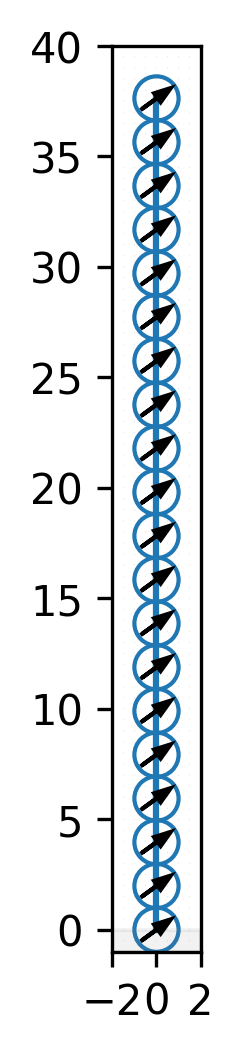

In [161]:
n = 20

no_field_ens = CanonicalEnsemble(sigma=1, r_f=2, beta=1, H=0)

c, d = 7, 3 # c ... number of constraints per state, d ... number of dimensions per state

# construct box constraints of the form (1, 2*pi] for the dipole moment 
A, b = np.zeros((c*n-5, d*n-2)), np.zeros((c*n-5))
eps = 1.e-5

for i in range(n):
    if i > 0:
        A[c*i-1,d*i-1] = -1
        
        # -r_f(1+eps) <= x_1 <= r_f(1+eps)
        A[c*i-2,d*i-1] = 1
        A[c*i-3,d*i-1] = -1
        
        b[c*i-2] = (1+eps)*ens.r_f
        b[c*i-3] = (1+eps)*ens.r_f
        
        # -r_f(1+eps) <= y_1 <= r_f(1+eps)
        A[c*i-4,d*i-2] = 1
        A[c*i-5,d*i-2] = -1
        
        b[c*i-4] = (1+eps)*ens.r_f
        b[c*i-5] = (1+eps)*ens.r_f
    
    if i > 1:
        # -r_f(1+eps) <= x_1 <= r_f(1+eps)
        A[c*i-2,d*(i-1)-1] = -1
        A[c*i-3,d*(i-1)-1] = 1
        
        # -r_f(1+eps) <= y_1 <= r_f(1+eps)
        A[c*i-4,d*(i-1)-2] = -1
        A[c*i-5,d*(i-1)-2] = 1
        
    A[c*i,d*i] = 1
    A[c*i+1,d*i] = -1

    b[c*i] = 2*np.pi
    b[c*i+1] = eps
    
no_field_problem = hp.Problem(A, b, no_field_ens)
problem = hp.Problem(A, b, ens)
    
starting_point = [[np.pi / 5]] + [[0, .99*ens.r_f*i, np.pi / 5] for i in range(1, n)]
draw_state(starting_point, ens, xlim=[-2, 2], ylim=[-1, 40])
plt.show()

In [162]:
n = 20

c, d = 3, 3 # c ... number of constraints per state, d ... number of dimensions per state

A, b = np.zeros((c*n-1, d*n-2)), 1e-5*np.ones((c*n-1))

for i in range(n):
    if i > 0:
        A[c*i-1,d*i-1] = -1
    
    A[c*i,d*i] = 1
    A[c*i+1,d*i] = -1

    b[c*i] = 2*np.pi
    
#Hs = [0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.5, 3, 4, 5, 6]
#Hs = [0, .5, 1, 1.5, 2, 2.5, 3, 4, 5, 6]
Hs = [0, 1, 2, 4, 6]
mu_maxs = [1, 3]

problems = [hp.Problem(A, b, CanonicalEnsemble(sigma=1, r_f=2, beta=1, H=H, mu_max=mu_max)) for H in Hs for mu_max in mu_maxs]
starting_point = [np.pi / 5]

for i in range(1, n):
    starting_point += [0, .99*ens.r_f*i, np.pi / 5]

n_samples = 350
thinning = 3000
n_chains = 10


def warmup(args):
    _, _, problem, starting_point = args
    mcs = [hp.MarkovChain(problem, hp.GaussianHitAndRunProposal, starting_point) for i in range(n_chains)]
    rngs = [hp.RandomNumberGenerator(42, i) for i in range(n_chains)]

    elapsed = time.time()
    accrate, states = hp.sample(mcs, rngs, 350, thinning=thinning, n_threads=n_chains)
    elapsed = time.time() - elapsed

    return (elapsed, accrate), states


def sample(args):
    _, _, problem, starting_points = args
    mcs = [hp.MarkovChain(problem, hp.GaussianHitAndRunProposal, starting_points[i]) for i in range(n_chains)]
    rngs = [hp.RandomNumberGenerator(42, i) for i in range(n_chains)]

    elapsed = time.time()
    accrate, states = hp.sample(mcs, rngs, 350, thinning=thinning, n_threads=n_chains)
    elapsed = time.time() - elapsed

    return (elapsed, accrate), states


no_field_args = [(problem.model.model.H, problem.model.model.mu_max, problem, starting_point) for problem in problems[:2]]

In [ ]:
n_parallel = 60
n_worker = int(n_parallel/n_chains)
print(n_worker)

parallel = True
if parallel:
    with NestablePool(max_workers=n_worker) as p:
        _data = p.map(warmup, no_field_args)
else:
    _data = []
    for arg in no_field_args:
        _data.append(warmup(arg))

no_field_states = {}
    
for i, entry in enumerate(_data):
    H, mu_max, _, _ = no_field_args[i]
    no_field_states[(H, mu_max)] = entry
    
with open('no_field_magnetic_raw', 'wb') as fhandle:
    dill.dump(states, fhandle)

6


In [ ]:
args = []
for i, problem in enumerate(problems):
    H, mu_max = problem.model.model.H, problem.model.model.mu_max
    _states = no_field_states[(0, mu_max)][-1]
    rng = hp.RandomNumberGenerator(i)
    u = hp.Uniform(0, _states.shape[0])
    v = hp.Uniform(0, _states.shape[1])
    starting_points = [_states[int(u(rng)),int(v(rng))] for j in range(n_chains)] # draw n_chains states from the equilibirum distribution without applied field
    args += [(H, mu_max, problem, starting_points)]


In [ ]:
n_parallel = 60
n_worker = int(n_parallel/n_chains)

parallel = True
if parallel:
    with NestablePool(max_workers=n_worker) as p:
        _data = p.map(sample, args)
else:
    _data = []
    for arg in args:
        _data.append(sample(arg))

states = {}
    
for i, entry in enumerate(_data):
    H, mu_max, _, _ = args[i]
    states[(H, mu_max)] = entry
    
with open('magnetic_raw', 'wb') as fhandle:
    dill.dump(states, fhandle)

In [163]:
def compute_mean_nn_distance(states):
    mean_nn_dist = []
    for chain in states:
        for state in chain:
            diff = np.diff(flatten(np.hstack([[0, 0], state])).reshape(-1, 3)[:,:2], axis=0)
            mean_nn_dist.append(np.mean(np.linalg.norm(diff, axis=1)))
            
    return np.mean(mean_nn_dist)
        
def compute_end_to_end_distance(states):
    Ree = []
    N = np.ceil(len(states[0,0]) / 3)
    for chain in states:
        for state in chain:
            mean_nn_dist = compute_mean_nn_distance([[state]])
            Ree.append(np.linalg.norm(flatten(state)[-3:-1]) / (mean_nn_dist * N))
            
    return Ree

In [164]:
def f(_, states):
    Ree = compute_end_to_end_distance(states)
    mean = np.mean(Ree)
    return mean, mean - np.quantile(Ree, 0.05), np.quantile(Ree, 0.95) - mean


In [165]:
with open('magnetic_raw', 'rb') as fhandle:
    states = dill.load(fhandle)

with Pool(n_parallel) as p:
    results = p.starmap(f, [states[key] for key in states])

Rees = {key: results[i] for i, key in enumerate(states)}

print(Rees)

{(0, 1): (0.6470625621106902, 0.20281288982599183, 0.2933905554859967), (0, 3): (0.9282396966668959, 0.023821514305782165, 0.018922698947791194), (1, 1): (0.6370853583671712, 0.25085619205717646, 0.29611787848391025), (1, 3): (0.9338232709710405, 0.018060324902320124, 0.010755649312290783), (2, 1): (0.6640337272627154, 0.1915189033217478, 0.20239235938852973), (2, 3): (0.9349808975289523, 0.015799929033590843, 0.010051182975071682), (4, 1): (0.6718432081088505, 0.328982721708781, 0.276715584373731), (4, 3): (0.9380170045831164, 0.010110383114953714, 0.008319083197617094), (6, 1): (0.6557411830854557, 0.3175436686389581, 0.289342802416907), (6, 3): (0.9385629992163875, 0.00980051459146003, 0.007598446518400137)}


In [174]:
def rhat(_, states):
    return np.max(hp.rhat(states))

with Pool(n_parallel) as p:
    rhats = p.starmap(rhat, [states[key] for key in states])

for i, key in enumerate(states):
    print(key, rhats[i])


(0, 1) 2.2988825304157525
(0, 3) 2.920408695394167
(1, 1) 2.0465833334197163
(1, 3) 2.4623558626450324
(2, 1) 2.0441695328830116
(2, 3) 2.5947809991790125
(4, 1) 2.4135579749266447
(4, 3) 2.4611487162520436
(6, 1) 2.394829270729719
(6, 3) 2.685213961182422


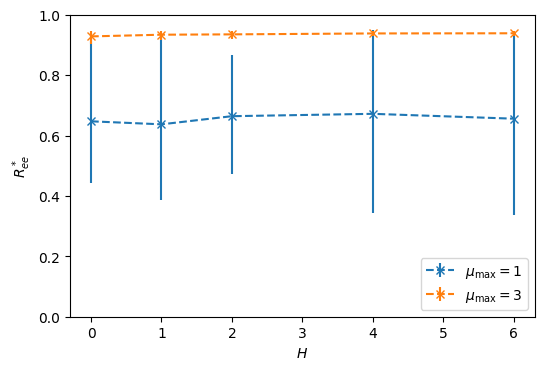

In [167]:
plt.figure(dpi=100)
for mu_max in mu_maxs:
    data = np.array([Rees[(H, mu_max)] for H in Hs])
    Ree_mean = data[:,0]
    Ree_err = data[:,1:].T
    plt.errorbar(Hs, Ree_mean, yerr=Ree_err, label=r'$\mu_{\mathrm{max}} = ' + str(mu_max) + '$', marker='x', linestyle='dashed')
    plt.ylim([0, 1])

plt.ylabel(r'$R_{ee}^*$')
plt.xlabel(r'$H$')
plt.legend(loc='lower right')
plt.show()

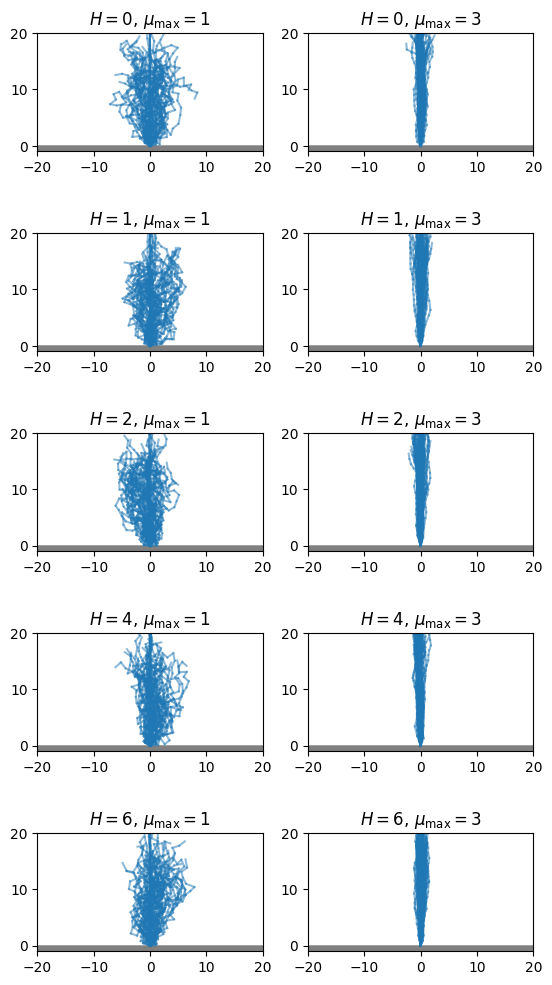

In [177]:
fig, axs = plt.subplots(len(Hs), len(mu_maxs), dpi=100, figsize=(6.4, 12.8))

N = 5 # number of samples per chain to draw

for i, H in enumerate(Hs):
    for j, mu_max in enumerate(mu_maxs):
        _states = states[(H, mu_max)][-1]
        ens = problems[list(states).index((H, mu_max))].model.model
        
        n_chains = _states.shape[0]
        n_samples = _states.shape[1]
        
        thinning = int(n_samples / N)
        
        axs[i, j].set_title(r"$H = " + str(H) + "$, $\mu_{\mathrm{max}} = " + str(mu_max) + "$") 
        for k in range(n_chains):
            for l in range(N):
                draw_state(_states[k,l*thinning], ens, fig=fig, ax=axs[i, j], alpha=.5, xlim=[-n, n], ylim=[-1,n])#, xlim=xlim, ylim=ylim)

plt.show()